## Objetivo

Este notebook tem como principal função processar os registros de vendas e identificar insights que podem ser úteis para o negócio. Para isso, nossa linha guia será o questionamento. De nada adiantar ter dados e não saber o que fazer com eles, por isso priorizamos, antes de qualquer coisa, definir o que buscamos. Em outras palavras, não vamos apenas explorar por explorar, vamos explorar o que nos permite respostar as dúvidas que temos em relação ao negócio. De nada adianta exibir diversas estatísticas descritivas com um método X se elas não vão ser insumo para nada.

Dito isso, começamos este trabalho definindo os parâmetros principais para execução do notebook. Nossa principal variável é o caminho de execução, que vai variar de acordo com o sistema operacional e como os diretórios são organizados no computador, portanto é um ponto de atenção. Os dados serão carregados no escopo global, enquanto as manipulações serão executadas dentro de funções.

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BASE_PATH = "C:/Users/99818854/Projetos/GitRep/Simulacoes"

In [3]:
# Carrega bases para processamento
sales = pd.read_excel(f"{BASE_PATH}/data/ecommerce.xlsx", sheet_name="Vendas").sort_values("Data", ascending=True)
customers = pd.read_csv(f"{BASE_PATH}/data/ml/ecommerce - orange - perfil de clientes.csv")

# Organiza perfil de clientes em árvore, facilitando a conversão
customer_groups = {}
for i in range(0, len(customers)):
    customer_groups[customers["Cliente"].values[i]] = customers["Grupo"].values[i]

## O que desejamos saber?

Toda o nosso processo de análise será ponderado pelas questões que desejamos responder. Neste momento, antes de começar nosso trabalho de regressão ou classificação, é bom entender sobre o nosso negócio. Não adianta muito termos em mãos diversos modelos robustos se não sabemos como nosso sistema se comporta. Já sabemos como os compradores gastam, agora vamos olhar para a nossa loja e identificar como ela gera retorno e, sobretudo, como nossas campanhas de marketing auxiliam na receita e nas vendas. Será que há diferença? Vamos seguindo e respondendo as perguntas aos poucos.

&check; Quanto foi vendido (R$) em cada categoria?

&check; Quais os produtos que mais geraram receita (R$)? Quais os que menos geraram receita (R$)?

&check; Quais os clientes que mais gastaram (R$)? Eles pertencem a um mesmo perfil?

&check; Qual a eficiência da campanha de marketing?

&cross; Outros...

### Quanto foi vendido (R$) em cada categoria?

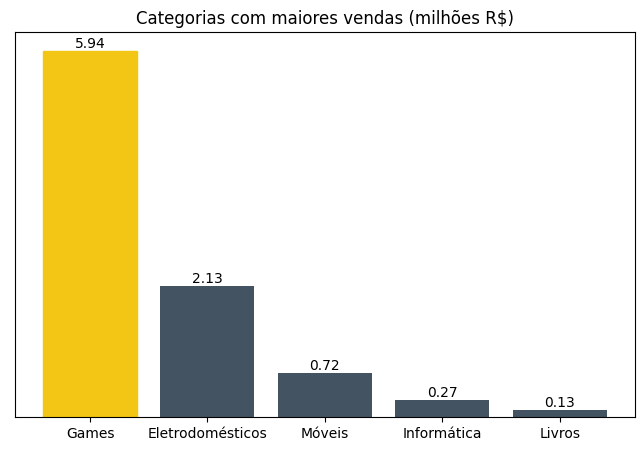

In [21]:
def revenue_by_category(df: pd.DataFrame):
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    group = df.groupby("Categoria")["Preço de Venda (R$)"].sum().sort_values(ascending=False)
    chart = ax.bar(group.index, group.values, color="#435362")
    ax.bar_label(chart, labels=[round(v / 1000000, 2) for v in group.values])
    ax.set_title("Categorias com maiores vendas (milhões R$)")
    ax.axes.yaxis.set_visible(False)
    chart[0].set_color("#f3c615")
    plt.show()


revenue_by_category(sales)

### Quais os produtos que mais geraram receita (R$)? Quais os que menos geraram receita (R$)?

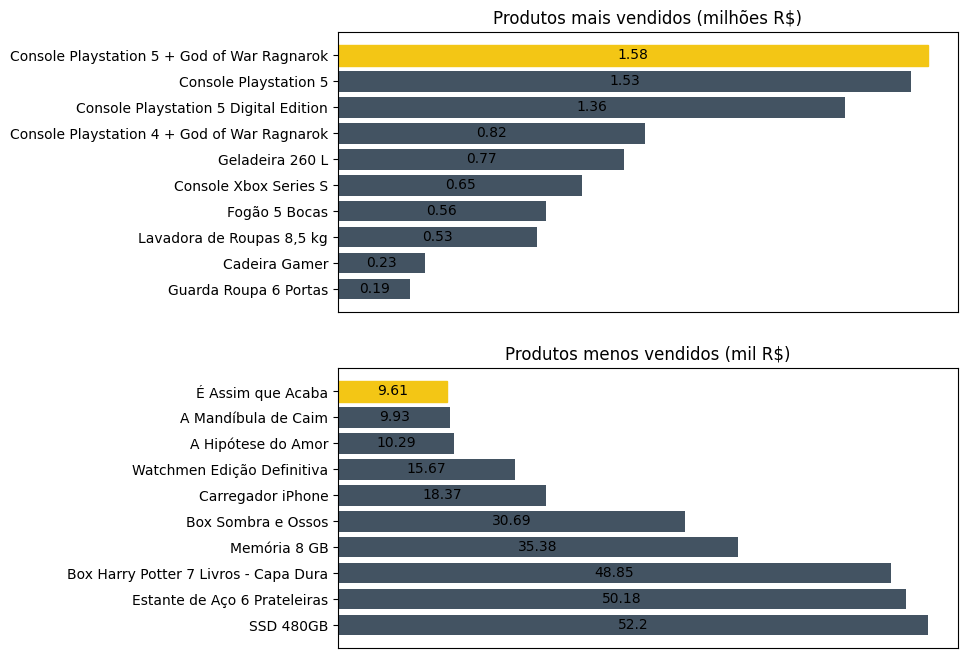

In [22]:
def revenue_by_product(df: pd.DataFrame):
    fig, ax = plt.subplots(2, 1, figsize=(8, 8))
    group = df.groupby("Produto")["Preço de Venda (R$)"].sum().nlargest(n=10)
    chart = ax[0].barh(group.index, group.values, color="#435362")
    ax[0].bar_label(chart, labels=[round(v / 1000000, 2) for v in group.values], label_type="center")
    ax[0].set_title("Produtos mais vendidos (milhões R$)")
    ax[0].invert_yaxis()
    ax[0].axes.xaxis.set_visible(False)
    chart[0].set_color("#f3c615")

    group = df.groupby("Produto")["Preço de Venda (R$)"].sum().nsmallest(n=10)
    chart = ax[1].barh(group.index, group.values, color="#435362")
    ax[1].bar_label(chart, labels=[round(v / 1000, 2) for v in group.values], label_type="center")
    ax[1].set_title("Produtos menos vendidos (mil R$)")
    ax[1].invert_yaxis()
    ax[1].axes.xaxis.set_visible(False)
    chart[0].set_color("#f3c615")

    plt.show()


revenue_by_product(sales)

### Quais os clientes que mais gastaram (R$)? Eles pertencem a um mesmo perfil?

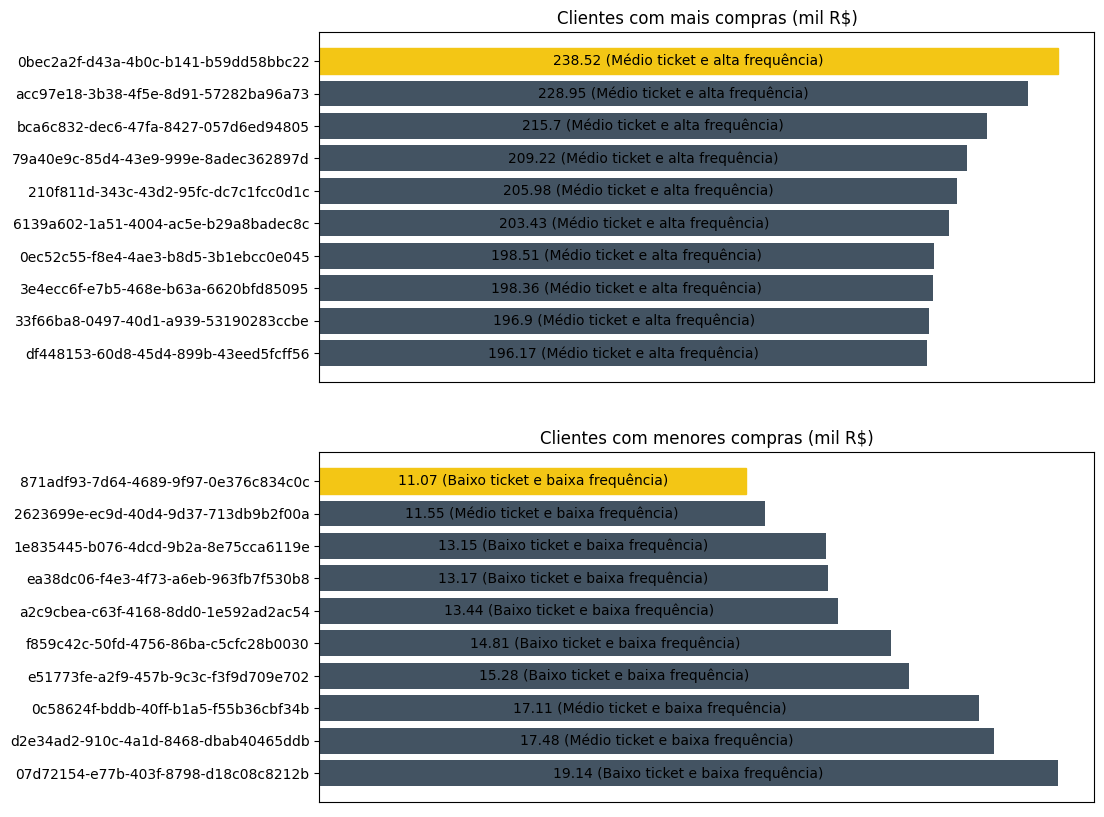

In [26]:
def revenue_by_customer(df: pd.DataFrame, customers: dict):
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    group = df.groupby("Cliente")["Preço de Venda (R$)"].sum().nlargest(n=10)
    chart = ax[0].barh(group.index, group.values, color="#435362")
    ax[0].bar_label(chart, labels=[f"{round(group.values[i] / 1000, 2)} ({customers[group.index[i]]})" for i in range(0, len(group))], label_type="center")
    ax[0].set_title("Clientes com mais compras (mil R$)")
    ax[0].invert_yaxis()
    ax[0].axes.xaxis.set_visible(False)
    chart[0].set_color("#f3c615")

    group = df.groupby("Cliente")["Preço de Venda (R$)"].sum().nsmallest(n=10)
    chart = ax[1].barh(group.index, group.values, color="#435362")
    ax[1].bar_label(chart, labels=[f"{round(group.values[i] / 1000, 2)} ({customers[group.index[i]]})" for i in range(0, len(group))], label_type="center")
    ax[1].set_title("Clientes com menores compras (mil R$)")
    ax[1].invert_yaxis()
    ax[1].axes.xaxis.set_visible(False)
    chart[0].set_color("#f3c615")

    plt.show()


revenue_by_customer(sales, customer_groups)

### Qual a eficiência da campanha de marketing?

c:\Users\99818854\Projetos\GitRep\Simulacoes\.venv\lib\site-packages\ipykernel_launcher.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator


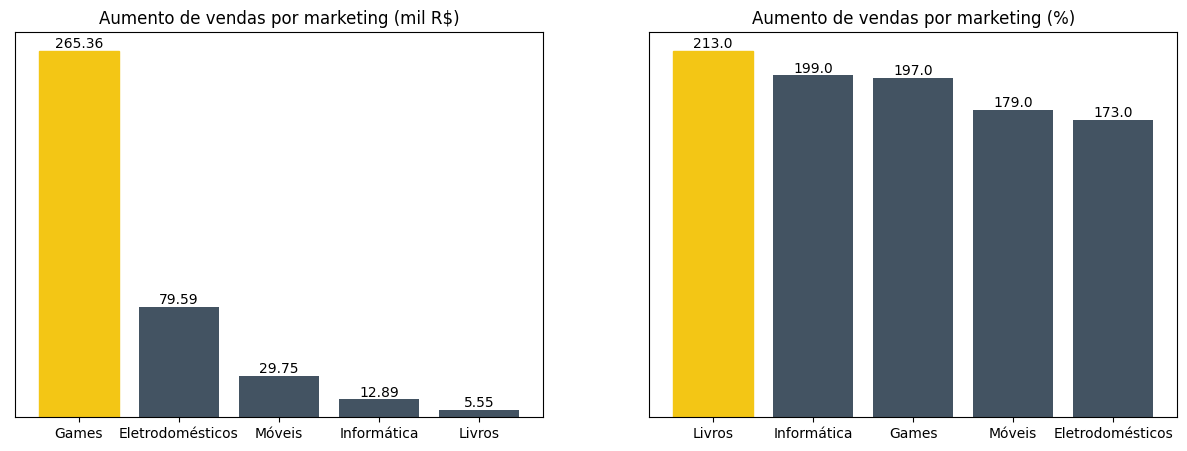

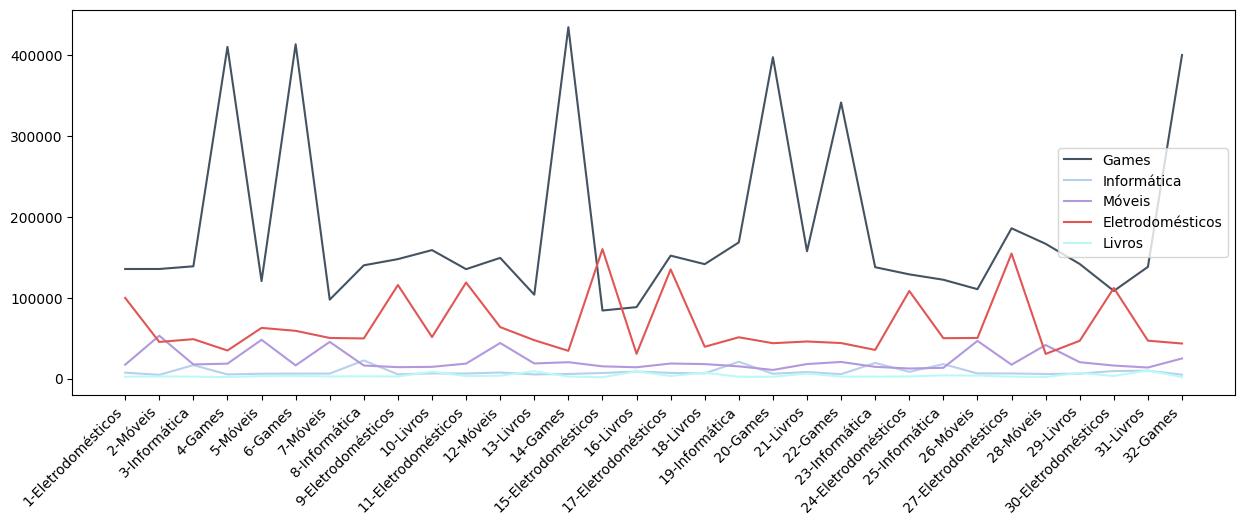

In [71]:
def marketing_efficiency(df: pd.DataFrame):
    # Encontra as datas de execução das campanhas de marketing, junto das categorias.
    # Nossa tabela resumo terá como linhas as campanhas de marketing efetuadas, com as vendas
    # em cada categoria como colunas (pivot)
    mkt_table = []
    categories = set(df["Categoria"].values)
    current, start, end = df["Campanha em Curso"].values[0], df["Data"].values[0], None

    for i in range(0, len(df)):
        if df["Campanha em Curso"].values[i] != current:
            # Padroniza datas
            start_date = str(start).split("T")[0]
            end_date = str(df["Data"].values[i - 1]).split("T")[0]

            # Inicializa o registro de dados e calcula a veda de cada categoria durante
            # o período da capmanha em curso
            row = {"Campanha": current, "Início": start_date, "Fim": end_date}
            for category in categories:
                sub = df.loc[(df["Data"] >= start_date) & (df["Data"] <= end_date) & (df["Categoria"] == category)]
                row[category] = sum(sub["Preço de Venda (R$)"].values)

            # Salva os dados da campanha e atualiza as variáveis de iteração
            mkt_table.append(row)
            current = df["Campanha em Curso"].values[i]
            start = df["Data"].values[i]

    # Converte a tabela de dados e inicializa exibição gráfica
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    mkt_table = pd.DataFrame(mkt_table)

    # Calcula aumento de vendas (absoluto e relativo) durante as campanhas
    x, y1, y2 = [], [], []
    for category in categories:
        mean_revenue = mkt_table.loc[mkt_table["Campanha"] != category][category].mean()
        mean_increase = (mkt_table.loc[mkt_table["Campanha"] == category][category] - mean_revenue).mean()
        relative_increase = mean_increase * 100 / mean_revenue

        x.append(category)
        y1.append(mean_increase)
        y2.append(relative_increase)

    # Estrutura a visualização absoluta
    serie = pd.Series(y1, index=x).sort_values(ascending=False)
    chart = ax[0].bar(serie.index, serie.values, color="#435362")
    chart[0].set_color("#f3c615")
    ax[0].set_title("Aumento de vendas por marketing (mil R$)")
    ax[0].axes.yaxis.set_visible(False)
    ax[0].bar_label(chart, [round(v / 1000, 2) for v in serie.values])

    # Estrutura a visualização relativa
    serie = pd.Series(y2, index=x).sort_values(ascending=False)
    chart = ax[1].bar(serie.index, serie.values, color="#435362")
    chart[0].set_color("#f3c615")
    ax[1].set_title("Aumento de vendas por marketing (%)")
    ax[1].axes.yaxis.set_visible(False)
    ax[1].bar_label(chart, [round(v, 0) for v in serie.values])

    # Organiza plot de campanhas
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    colors, selected = ["#435362", "#E15554", "#B298DC", "#B8D0EB", "#B9FAF8"], []
    x = [f"{i + 1}-{mkt_table['Campanha'].values[i]}" for i in range(0, len(mkt_table))]
    
    for category in categories:
        i = np.random.randint(0, len(colors))
        while i in selected: i = np.random.randint(0, len(colors))
        selected.append(i)
        ax.plot(x, mkt_table[category].values, label=category, color=colors[i])
    ax.legend()
    ax.set_xticklabels(x, rotation=45, ha="right")

    plt.show()


marketing_efficiency(sales)